# Wong-Wang full model implemented in Numba
- Inference using CDE.MAF
- without torch and sbi dependency

In [1]:
import os
import vbi
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from vbi.utils import timer
import multiprocessing as mp
import matplotlib.pyplot as plt
from multiprocessing import Pool
from vbi.cde import MAFEstimator
from vbi.models.numba.ww import WW_sde
from vbi.feature_extraction.features_utils import get_fcd
from vbi import (
    extract_features,
    get_features_by_domain,
    get_features_by_given_names,
    update_cfg,
)

warnings.simplefilter("ignore")

In [2]:
seed = 42
np.random.seed(seed)

LABESSIZE = 10
plt.rcParams["axes.labelsize"] = LABESSIZE
plt.rcParams["xtick.labelsize"] = LABESSIZE
plt.rcParams["ytick.labelsize"] = LABESSIZE

In [3]:
path = "output/ww_full_numba_cde"
os.makedirs(path, exist_ok=True)
LOAD_DATA = True

In [4]:
def wrapper(par, p=None, cfg=None, extract_feature=False):
    """Wrapper function to run the WW_sde model with given parameters."""
    par = deepcopy(par)
    sde = WW_sde(par)

    if p is not None:
        p = dict(
            G_exc=p#[0],
            # ext_current=p[1],
        )
    else:
        p = {}

    data = sde.run(p)
    S_t = data["t"]
    S_d = data["S"]
    bold_d = data["bold_d"]
    bold_t = data["bold_t"]

    if extract_feature:
        stat = extract_features(
            [bold_d.T],
            1 / par["dt"] / par["tr"],
            cfg,
            n_workers=1,
            verbose=False,
        )
        values = stat.values
        labels = stat.labels

        return values, labels

    if par["RECORD_S"]:
        return S_t, S_d, bold_t, bold_d
    else:
        return bold_t, bold_d


def batch_run(par, p, cfg, n_workers=1):

    n = len(p)

    def update_bar(_):
        pbar.update()

    with Pool(processes=n_workers) as pool:
        with tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper, args=(par, p[i], cfg, True), callback=update_bar
                )
                for i in range(n)
            ]
            stat_vec = [res.get()[0] for res in async_results]
    return stat_vec

In [5]:
# --- define feature extraction configuration ---

cfg = get_features_by_domain("connectivity")
cfg = get_features_by_given_names(cfg, ["fcd_stat"])
cfg = update_cfg(cfg, "fcd_stat", parameters={"k": None, "win_len": 30, "TR": 0.3})
# report_cfg(cfg)

In [6]:
D = vbi.LoadSample(nn=84)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

number of nodes: 84


In [25]:
# --- Simulation Parameters ---
theta_true = [1.90]  # G_exc, 
# theta_true = [2.216]  # , 0.009]  #
par = dict(
    weights=weights,
    nn=nn,
    dt=2.5,  # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000,  # ms
    G_exc=theta_true[0],
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=True,
    s_decimate=10,
    tr=300.0,  # ms
    seed=42,
)

if not LOAD_DATA:
    S_t, S_d, bold_t, bold_d = wrapper(par)
    df_obs = extract_features(
        [bold_d.T],
        1 / par["dt"] / par["tr"],
        cfg,
        n_workers=1,
        output_type="dataframe",
        verbose=False,
    )
    df_obs.to_csv(path + "/df_obs.csv", index=False)
    np.savez(
        path + "/data_obs.npz",
        S_t=S_t,
        S_d=S_d,
        bold_t=bold_t,
        bold_d=bold_d,
        theta=theta_true,
    )

    print(df_obs[["fcd_full_ut_std"]].values[0])

[0.13871282]


In [8]:
if LOAD_DATA:
    data = np.load(path + "/data_obs.npz")
    S_t = data["S_t"]
    S_d = data["S_d"]
    bold_t = data["bold_t"]
    bold_d = data["bold_d"]
    theta_true = data["theta"].tolist()
    print(theta_true)

[2.216]


In [26]:
print(S_t.shape, S_d.shape, bold_t.shape, bold_d.shape)

(9599,) (9599, 84) (799,) (799, 84)


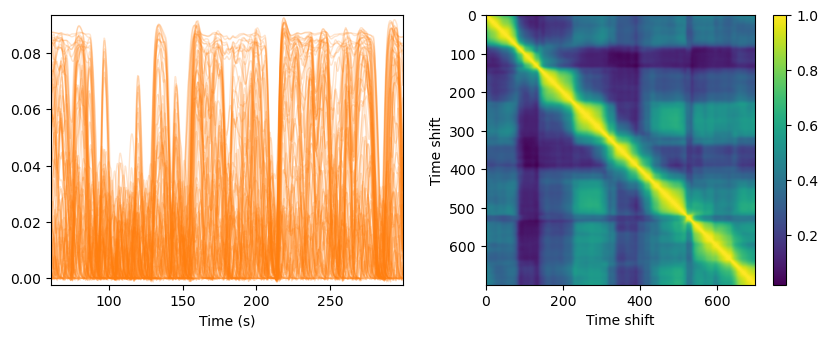

In [27]:
fcd = get_fcd(bold_d.T, win_len=30, TR=0.3)['full']

plt.figure(figsize=(10, 3.5))
ax1 = plt.subplot(121)
ax1.plot(bold_t/1000, bold_d, lw=1, alpha=0.2, color="C1")
ax1.set_xlabel('Time (s)')
ax1.margins(x=0, y=0.01)
ax2 = plt.subplot(122)
im = ax2.imshow(fcd, cmap="viridis", aspect="equal")
plt.colorbar(im, ax=ax2)
plt.xlabel('Time shift')
plt.ylabel('Time shift')
plt.show()

To estimate `G_exc`:
1. Set appropriate prior intervals.  
2. Generate simulated training data.  
3. Extract relevant features.  
4. Train neural network to build posterior.  
5. Sample from posterior distribution.  
6. Visualize posterior distributions.

In [28]:
from vbi.utils import BoxUniform

num_sim = 200
gmin, gmax = 0., 2.5
prior_min = [gmin]
prior_max = [gmax]
prior = BoxUniform(low=prior_min, high=prior_max)
theta = prior.sample((num_sim,), seed=seed)

In [29]:
# ext_current = theta[:, 1].numpy().squeeze()
G_exc = theta[:, 0].squeeze()

par = dict(
    weights=weights,
    nn=nn,
    dt=2.5,  # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000,  # ms
    G_exc=0.0,
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=False,
    s_decimate=10,
    tr=300.0,  # ms
    seed=42,
)

In [13]:
if not LOAD_DATA:
    X = batch_run(par, theta, cfg, n_workers=10)
    

In [30]:
if not LOAD_DATA:
    X_df = pd.DataFrame(np.array(X).squeeze(), columns=df_obs.columns)
    X_df.to_pickle(path+"dataframe_X.pkl")
    remained_columns = X_df.std() > 1e-5
    X_df = X_df.loc[:, remained_columns]
    x = (X_df.values).astype(np.float32)
    np.savez(path+"training_data.npz", x=x, theta=theta)
    remained_columns.to_csv(path+"remained_columns.csv", index=False)
else:
    data = np.load(path+"training_data.npz")
    x = data["x"]
    theta = data["theta"]
    remained_columns = pd.read_csv(path+"remained_columns.csv").values
    remained_columns = remained_columns.squeeze().astype(bool)

In [31]:
x.shape, theta.shape, type(remained_columns)

((200, 22), (200, 1), numpy.ndarray)

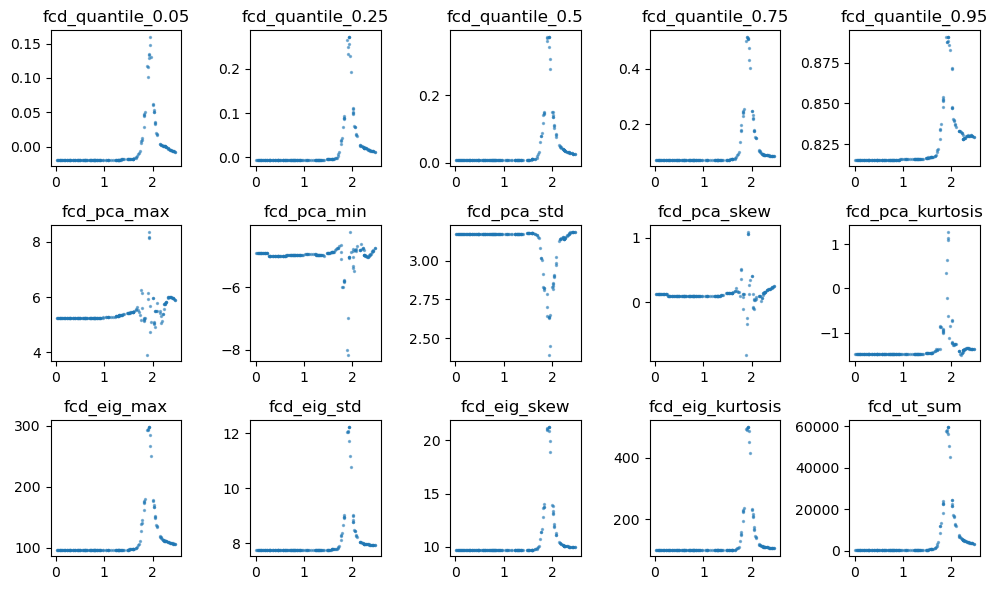

In [32]:
# plot scatter plot of the features
df_obs = pd.read_csv(path+"/df_obs.csv")
column_labels = df_obs.columns
column_labels = column_labels[remained_columns]
fig, ax = plt.subplots(3,5, figsize=(10,6))
for i in range(3):
    for j in range(5):
        ax[i,j].scatter(theta, x[:, i*5+j], s=2, alpha=0.5)
        label = column_labels[i*5+j]
        label = label.replace("full_", "")
        ax[i,j].set_title(label)

plt.tight_layout()

In [33]:
xo = df_obs.loc[:,remained_columns].values.astype(np.float32)
xo.shape, theta.shape, x.shape
type(theta), type(x), xo.dtype, theta.dtype, x.dtype

(numpy.ndarray,
 numpy.ndarray,
 dtype('float32'),
 dtype('float64'),
 dtype('float32'))

In [34]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
import autograd.numpy as anp

rng = anp.random.RandomState(seed)
maf_estimator = MAFEstimator(n_flows=4, hidden_units=64)
# maf_estimator = MAFEstimator(param_dim=1, feature_dim=1, n_flows=4, hidden_units=64)
maf_estimator.train(
    theta.astype(np.float32), x.astype(np.float32)[:,:2], n_iter=500, learning_rate=2e-4
)
# print("best epoch:", maf_estimator.best_epoch, "best val:", maf_estimator.best_val_loss)
samples = maf_estimator.sample(xo[:, :2], n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true, samples)
print("True parameters:      ", theta_true)
print("MAF mean estimate:    ", np.mean(samples, axis=0))
print("Posterior shrinkage:  ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:    ", np.array2string(zscore, precision=3, separator=", "))

Inferred dimensions: param_dim=1, feature_dim=2


Training: 100%|██████████| 500/500 [00:07<00:00, 62.90it/s, patience=0/20, train=0.9182, val=1.0682] 


True parameters:       [1.9]
MAF mean estimate:     [1.9301355]
Posterior shrinkage:   [0.999]
Posterior z-score:     [1.596]


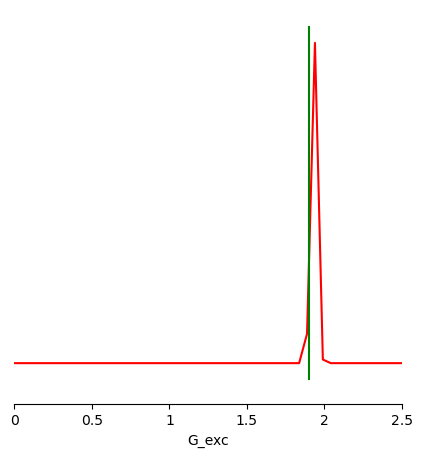

In [35]:
from vbi.plot import pairplot_numpy

limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array(theta_true).reshape(1, -1),
    labels=["G_exc"],
    offdiag='kde',
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)